# Preparando o Ambiente

In [382]:
!pip install LTNtorch

In [383]:
import matplotlib.pyplot as plt
import ltn
import torch
import numpy as np
import math

# Codes originais (não é necessário usar)

ltn_relations_milena.py (Nao rodar!)

In [384]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def get_coordinates( bb ):
    x0 = bb[ 0 ]
    y0 = bb[ 1 ]
    x1 = bb[ 0 ] + bb[ -2 ]
    y1 = bb[ 1 ] + bb[ -1 ]
    return [ x0, y0, x1, y1 ]


def calculate_angle( bb1, bb2 ):
    c2 = np.array( (bb2[ 0 ], bb2[ 1 ]) )
    c1 = np.array( (bb1[ 0 ], bb1[ 1 ]) )

    x = c2 - c1

    return np.angle( x[ 0 ] + 1j * x[ 1 ], deg = True )


def translate_bbs( bb1: tf.Tensor, bb2: tf.Tensor, is_class_first = False,
                   is_yolo_format = False ):
    """
    Translate bounding box coordinates based on specified conditions.

    Parameters:
        bb1 (tensor): The coordinates of the first bounding box.
        bb2 (tensor): The coordinates of the second bounding box.
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Returns:
        tuple: Translated coordinates of the first and second bounding boxes in the format (x, y, w, h).

    Example:
        bb1 = tf.constant([0.3, 0.3, 0.2, 0.2])
        bb2 = tf.constant([0.3, 0.3, 0.1, 0.1])
        translated_bb1, translated_bb2 = translate_bbs(bb1, bb2, is_class_first=True, is_yolo_format=True)
    """

    if is_class_first :
        if is_yolo_format :
            x1, y1 = bb1[ ..., 1 ] - bb1[ ..., 3 ] / 2.0, bb1[ ..., 2 ] - bb1[ ..., 4 ] / 2.0
            x2, y2 = bb2[ ..., 1 ] - bb2[ ..., 3 ] / 2.0, bb2[ ..., 2 ] - bb2[ ..., 4 ] / 2.0
            w1, h1, w2, h2 = bb1[ ..., 3 ], bb1[ ..., 4 ], bb2[ ..., 3 ], bb2[ ..., 4 ]
        else :
            x1, y1, w1, h1 = bb1[ ..., 1 ], bb1[ ..., 2 ], bb1[ ..., 3 ], bb1[ ..., 4 ]
            x2, y2, w2, h2 = bb2[ ..., 1 ], bb2[ ..., 2 ], bb2[ ..., 3 ], bb2[ ..., 4 ]

    else :
        if is_yolo_format :
            x1, y1 = bb1[ ..., 0 ] - bb1[ ..., 2 ] / 2.0, bb1[ ..., 1 ] - bb1[ ..., 3 ] / 2.0
            x2, y2 = bb2[ ..., 0 ] - bb2[ ..., 2 ] / 2.0, bb2[ ..., 1 ] - bb2[ ..., 3 ] / 2.0
            w1, h1, w2, h2 = bb1[ ..., 2 ], bb1[ ..., 3 ], bb2[ ..., 3 ], bb2[ ..., 3 ]
        else :
            x1, y1, w1, h1 = bb1[ ..., 0 ], bb1[ ..., 1 ], bb1[ ..., 2 ], bb1[ ..., 3 ]
            x2, y2, w2, h2 = bb2[ ..., 0 ], bb2[ ..., 1 ], bb2[ ..., 2 ], bb2[ ..., 3 ]

    return (x1, y1, w1, h1), (x2, y2, w2, h2)

    return (x1, y1, w1, h1), (x2, y2, w2, h2)


@tf.function
def O( bb1: tf.Tensor, bb2: tf.Tensor, is_yolo_format = True, is_class_first = False ):
    """
    Check if two bounding boxes overlap.

    Parameters:
        bb1 (tensor): The coordinates of the first bounding box.
        bb2 (tensor): The coordinates of the second bounding box.
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Returns:
        bool: True if the bounding boxes overlap, False otherwise.

    Example:
        bb1 = tf.constant( [ 0.3, 0.3, 0.2, 0.2 ] )
        bb2 = tf.constant( [ 0.3, 0.3, 0.1, 0.1 ] )

        print( 'Check for O (True): ', O( bbs = (bb1, bb2), is_yolo_format = True, is_class_first = False ) )
    """
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs( bb1, bb2, is_yolo_format = is_yolo_format, is_class_first = is_class_first )

    condition1 = tf.logical_and( tf.greater_equal( x2, x1 ), tf.less_equal( x2 + w2, x1 + w1 ) )
    condition2 = tf.logical_and( tf.greater( y2, y1 ), tf.less( y2 + h2, y1 + h1 ) )

    return tf.logical_or( condition1, condition2 )


@tf.function
def PO( bb1: tf.Tensor, bb2: tf.Tensor, is_yolo_format = True, is_class_first = False ):
    """
    Check if two bounding boxes partially overlap.

    Parameters:
        bb1 (tensor): The coordinates of the first bounding box.
        bb2 (tensor): The coordinates of the second bounding box.
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Returns:
        bool: True if the bounding boxes partially overlap, False otherwise.

    Note: (x1,y1) and (x2,y2) ordered pair ar located in lowest-left corner of the bounding box
    """
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs( bb1, bb2, is_yolo_format = is_yolo_format, is_class_first = is_class_first )
    '''
    mesmo que:
                # PO 1
            ((x2 < x1) and ((x2 + w2) > x1) and
             (((y2 < y1) and ((y2 + h2) > y1)) or ((y2 + h2) > (y1 + h1))))

            # PO 2
            or (((x2 < x1) and ((x2 + w2) > x1) and ((x2 + w2) < (x1 + w1))) and
                ((((y2 + h2) > (y1 + h1)) and (y2 < (y1 + h1))) or ((y2 < y1) and ((y2 + h2) > y1))))

            # PO 3
            or (((x2 > x1) and ((x2 + h2) < (x1 + h1))) and
                ((((y2 + h2) > (y1 + h1)) and (y2 < (y1 + h1))) or ((y2 < y1) and ((y2 + h2) > y1))))

            # PO 4
            or (((x2 > x1) and (x2 < (x1 + w1)) and ((x2 + w2) > (x1 + w1))) and
                ((((y2 + h2) < (y1 + h1)) and ((y2 + h2) > y1)) or ((y2 > y1) and (y2 < (y1 + h1)))))
    Essas condições são para elementos iteraveis (list), mas aqui é adaptado para uso em tf.Tensor()
    '''

    # Condition 1
    condition1 = tf.logical_and(
            tf.logical_and( x2 < x1, x2 + w2 > x1 ),
            tf.logical_or(
                    tf.logical_and( y2 < y1, y2 + h2 > y1 ),
                    y2 + h2 > y1 + h1
            )
    )

    # Condition 2
    condition2 = tf.logical_and(
            tf.logical_and( x2 < x1, x2 + w2 > x1 ),
            tf.logical_and(
                    x2 + w2 < x1 + w1,
                    tf.logical_or(
                            tf.logical_and( y2 + h2 > y1 + h1, y2 < y1 + h1 ),
                            tf.logical_and( y2 < y1, y2 + h2 > y1 )
                    )
            )
    )

    # Condition 3
    condition3 = tf.logical_and(
            tf.logical_and( x2 > x1, x2 + h2 < x1 + h1 ),
            tf.logical_or(
                    tf.logical_and( y2 + h2 > y1 + h1, y2 < y1 + h1 ),
                    tf.logical_and( y2 < y1, y2 + h2 > y1 )
            )
    )

    # Condition 4
    condition4 = tf.logical_and(
            tf.logical_and( x2 > x1, tf.logical_and( x2 < x1 + w1, x2 + w2 > x1 + w1 ) ),
            tf.logical_or(
                    tf.logical_and( y2 + h2 < y1 + h1, y2 + h2 > y1 ),
                    tf.logical_and( y2 > y1, tf.logical_and( y2 < y1 + h1, y2 < y1 + h1 ) )
            )
    )

    # Final condition, combining all the above conditions with logical OR
    final_condition = tf.logical_or(
            tf.logical_or( condition1, condition2 ),
            tf.logical_or( condition3, condition4 )
    )
    return final_condition


@tf.function
def D( bb1: tf.Tensor, bb2: tf.Tensor, is_yolo_format = True, is_class_first = False ):
    """
    Check if two bounding boxes are disjoint.

    Parameters:
        bb1 (tuple): The coordinates of the first bounding box in the format (x1, y1, w1, h1).
        bb2 (tuple): The coordinates of the second bounding box in the format (x2, y2, w2, h2).
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Returns:
        bool: True if the bounding boxes are disjoint, False otherwise.
    """
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs( bb1, bb2, is_yolo_format = is_yolo_format, is_class_first = is_class_first )

    condition1 = tf.less( x2 + w2, x1 )
    condition2 = tf.greater( x2, x1 + w1 )
    condition3 = tf.greater( y2, y1 + h1 )
    condition4 = tf.less( y2 + h2, y1 )

    bool_tensor = tf.logical_or( tf.logical_or( condition1, condition2 ),
                                 tf.logical_or( condition3, condition4 ) )

    return bool_tensor


import matplotlib.pyplot as plt


def plot_bounding_boxes( bb1: tf.Tensor, bb2: tf.Tensor, is_class_first = False,
                         is_yolo_format = False ):
    """
    Plot two bounding boxes on a 2D plane.

    Parameters:
        bb1 (tensor): The coordinates of the first bounding box.
        bb2 (tensor): The coordinates of the second bounding box.
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Example:
        bb1 = tf.constant([0.3, 0.3, 0.2, 0.2])
        bb2 = tf.constant([0.3, 0.3, 0.1, 0.1])
        plot_bounding_boxes(bb1, bb2, is_class_first=True, is_yolo_format=True)
    """
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs( bb1, bb2, is_class_first, is_yolo_format )

    plt.figure( )
    plt.plot( [ x1 - w1 / 2, x1 + w1 / 2, x1 + w1 / 2, x1 - w1 / 2, x1 - w1 / 2 ],
              [ y1 - h1 / 2, y1 - h1 / 2, y1 + h1 / 2, y1 + h1 / 2, y1 - h1 / 2 ],
              'r' )

    plt.plot( [ x2 - w2 / 2, x2 + w2 / 2, x2 + w2 / 2, x2 - w2 / 2, x2 - w2 / 2 ],
              [ y2 - h2 / 2, y2 - h2 / 2, y2 + h2 / 2, y2 + h2 / 2, y2 - h2 / 2 ],
              'b' )

    plt.xlim( 0, 1 )
    plt.ylim( 0, 1 )
    plt.gca( ).invert_yaxis( )
    plt.show( )

generate_equally_spaced_bb.py

In [385]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import string

def get_rectangle(bb, edcolor='r'):
    """
    Create a rectangle patch for a given bounding box.

    This function creates and returns a rectangle patch object using the specified bounding box coordinates. The rectangle
    is defined by the center point (bb[0], bb[1]), width bb[2], and height bb[3]. The edge color of the rectangle can be
    customized using the optional 'edcolor' parameter.

    Parameters:
    bb (tuple): The bounding box coordinates in the format (center_x, center_y, width, height).
    edcolor (str, optional): The edge color of the rectangle (default is 'r').

    Returns:
    patches.Rectangle: A rectangle patch object representing the bounding box.

    Rectangle(xy=(0, 0), width=100, height=100, angle=0)

    Note:
    - The function assumes the bounding box coordinates are in the form (center_x, center_y, width, height).
    - The default edge color is 'r' (red).
    - The face color of the rectangle is set to 'none', resulting in an empty rectangle.
    """
    return patches.Rectangle((bb[0] - bb[2] / 2, bb[1] - bb[3] / 2), bb[2], bb[3], linewidth=2, edgecolor=edcolor,
                             facecolor='none')


def get_corners_coord(bb):
    x0 = bb[0] - bb[-2] / 2
    y0 = bb[1] - bb[-1] / 2
    x1 = bb[0] + bb[-2] / 2
    y1 = bb[1] + bb[-1] / 2

    top_left = (x0, y0)
    top_right = (x1, y0)
    bottom_left = (x0, y1)
    bottom_right = (x1, y1)

    return [top_left, top_right, bottom_left, bottom_right]


def get_interested_angles(bb):
    """
    Get the list of interested angles for a given bounding box.

    This function calculates and returns a list of angles of interest for a given bounding box. The angles include
    0.0, 90.0, -90.0, and 180.0, representing horizontal, vertical, and diagonal orientations.

    Parameters:
    bb (tuple): The bounding box coordinates in the format (center_x, center_y, width, height).

    Returns:
    list: A list of angles representing the interested angles for the bounding box.

    Example:
    # >>> bounding_box = (50, 50, 100, 100)
    # >>> angles = get_interested_angles(bounding_box)
    # >>> print(angles)
    [0.0, 90.0, -90.0, 180.0, 45.0, -45.0, 135.0, -135.0]

    Note:
    - The function assumes the bounding box coordinates are in the form (center_x, center_y, width, height).
    - The additional diagonal angles are calculated based on the corners of the bounding box.
    """
    angles = [0.0, 90.0, -90.0, 180.0]
    corners = get_corners_coord(bb)

    boxes = [(coord[0], coord[1], 0.1 * bb[2], 0.1 * bb[3]) for coord in corners]
    diag_angles = [calculate_angle(box, bb) for box in boxes]

    # print('diag_angles : ', diag_angles)

    return angles + diag_angles


def  generate_equally_spaced_points(bounding_box):
    """
    Generate equally spaced points within a bounding box in clockwise manner.

    This function calculates and generates equally spaced points within a given bounding box. The points are distributed
    based on different angles of interest within the box.

    Parameters:
    bounding_box (tuple): The bounding box coordinates in the format (center_x, center_y, width, height).

    Returns:
    list: A list of (x, y) coordinates representing the equally spaced points within the bounding box.
    """
    center_x, center_y, width, height = bounding_box
    points = []

    # Calculate spacing between points
    spacing_horizontal = width / 8
    spacing_vertical = height / 8

    diagonal_length = math.sqrt(width ** 2 + height ** 2)
    spacing_diagonal = diagonal_length / 8

    angles = get_interested_angles(bounding_box)
    angles.sort()

    pos_angles = [x for x in angles if x >= 0.0]
    neg_angles = [x for x in angles if x < 0.0]

    # ajustar angulos positivos para ordem crescente
    pos_angles.sort()
    # ajustar angulos negativos para ordem crescente
    neg_angles.sort()

    angles = pos_angles + neg_angles
    # para cada bb das direções, contando apartir do centro (1, 2 , 3 bb)
    for i in range(1, 4):

        # percorrendo os angulos de forma horária (pois está organizado : 0* -> 90 -> 180* e 180* -> -90 -> 0*)

        for angle in angles:

            x_signal = 1.0 if angle > 90.0 or angle < -90.0 else -1.0
            y_signal = 1.0 if angle > 0.0 else -1.0

            # horizontal
            if angle in [0.0, 180.0]:
                x = center_x + (i * spacing_horizontal * x_signal)
                y = center_y

            # diagonal
            if angle not in [0.0, 90.0, -90.0, 180.0]:
                x = center_x - i * spacing_diagonal * math.cos(math.radians(angle))
                y = center_y - i * spacing_diagonal * math.sin(math.radians(angle))

            # vertical
            if angle in [90.0, -90.0]:
                x = center_x
                y = center_y - (i * spacing_vertical * y_signal)

            points.append((x, y))


    return points


def plot_comparisons_diagonals(bb, boxes):
    """
    Plot comparisons of bounding boxes in relation to a main bounding box.

    This function generates a matplotlib figure with four subplots to visualize the comparisons of bounding boxes with
    respect to a main bounding box. The center_box and the main bounding box are plotted on each subplot for comparison.

    Parameters:
    bb (tuple): The bounding box coordinates of the main box in the format (x, y, width, height).
    boxes (list): A list of bounding box coordinates in the format [(x1, y1, width1, height1), (x2, y2, width2, height2), ...].

    Returns:
    None

    Example:
    bb = (10, 20, 50, 30)
    boxes = [(15, 25, 40, 20), (20, 30, 35, 25), (25, 35, 30, 30)]
    plot_comparisons_diagonals(bb, boxes)
    """
    # fig, axes = plt.subplots(nrows=2, ncols=2)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    # inSideLeftAltAbove, inSideLeftAltBelow, inSideRightAltAbove, inSideRightAltBelow
    name = list(string.ascii_uppercase)[:len(boxes)]

    # Plot center box and bb for comparision

    center_box = boxes[0]

    for ax in [ax1, ax2, ax3, ax4]:
        ax.add_patch(get_rectangle(bb, 'r'))
        ax.add_patch(get_rectangle(center_box, 'g'))
        ax.text(center_box[0], center_box[1], f'box : {name[0]}', ha='center', va='center', fontsize=12, color='blue')
        ax.invert_yaxis()
        ax.autoscale()

    # Add rectangles using patches.Rectangle()

    rect_inSideLeftAbove = get_rectangle(boxes[2], 'b')
    ax1.add_patch(rect_inSideLeftAbove)
    ax1.set_title(f'inSideLeftAltAbove : {inSideLeftAltAbove(boxes[2], center_box)}')
    ax1.text(boxes[2][0], boxes[2][1], f'box : {name[2]}', ha='center', va='center', fontsize=12, color='blue')

    rect_inSideRightAltAbove = get_rectangle(boxes[4], 'b')
    ax2.add_patch(rect_inSideRightAltAbove)
    ax2.set_title(f'inSideRightAltAbove : {inSideRightAltAbove(boxes[4], center_box)}')
    ax2.text(boxes[4][0], boxes[4][1], f'box : {name[4]}', ha='center', va='center', fontsize=12, color='blue')

    rect_inSideRightAltBelow = get_rectangle(boxes[6], 'b')
    ax3.add_patch(rect_inSideRightAltBelow)
    ax3.set_title(f'inSideRightAltBelow : {inSideRightAltBelow(boxes[6], center_box)}')
    ax3.text(boxes[6][0], boxes[6][1], f'box : {name[6]}', ha='center', va='center', fontsize=12, color='blue')

    rect_inSideLeftAltBelow = get_rectangle(boxes[8], 'b')
    ax4.add_patch(rect_inSideLeftAltBelow)
    ax4.set_title(f'inSideLeftAltBelow : {inSideLeftAltBelow(boxes[8], center_box)}')
    ax4.text(boxes[8][0], boxes[8][1], f'box : {name[8]}', ha='center', va='center', fontsize=15, color='blue')

    fig.tight_layout()
    plt.show()


def generate_eq_spaced_bbs_in_(bb, dictionary_with_letters=True):
    """
    Function to generate bounding boxes inside of a bounding box 'bb' in clockwise direction.

    Parameters:
    bb (list): list of bounding boxes in YOLO Format ([x_center, y_center, width, height]).
    dictionary_with_letters (bool): if boxes will be referred as Alphabetic letter ( A to Z ).

    Returns:
    bbs (list) : list of resulting bounding boxes

    The first element of the 'boxes' list is considered as the center_box. The subsequent bounding boxes are arranged
    in a clockwise manner starting from 0 degrees and progressing to 90 degrees, 180 degrees, -90 degrees, and the
    diagonal angle before 0 degrees.

    """

    # print(f'x : {bb[0]}, y : {bb[1]}')

    angles = get_interested_angles(bb)
    angles.sort()

    ## get boxes
    center_coord = generate_equally_spaced_points(bb)
    # print('center coordinates : ', center_coord)

    boxes = [[coord[0], coord[1], 0.1 * bb[2], 0.1 * bb[3]] for coord in center_coord]

    center_box = [bb[0], bb[1], 0.1 * bb[2], 0.1 * bb[3]]

    bbs = [center_box] + boxes


    if dictionary_with_letters:
        letters = list(string.ascii_uppercase)[:len(bbs) + 1]
        result_bbs = {letter: box for letter, box in zip(letters, bbs)}
        greater_box = [bb[0], bb[1], 2 * (result_bbs['N'][0] - bb[0]), 2 * (result_bbs['P'][1] - bb[1])]

        result_bbs[letters[-1]] = greater_box

        return result_bbs
    else:
        return bbs


def plot_all_bb_with_names(bb, boxes, name=list(string.ascii_uppercase)):
    """
    Plot bounding boxes with corresponding names on a matplotlib figure.

    Parameters:
    bb (tuple): The bounding box coordinates of the main box (x, y, width, height).
    boxes (list): A list of bounding box coordinates (x, y, width, height).
    name (list, optional): A list of names corresponding to each box. Default is a list of uppercase letters.

    Returns:
    None

    Example:
    bb = (10, 20, 50, 30)
    boxes = [(15, 25, 40, 20), (20, 30, 35, 25), (25, 35, 30, 30)]
    plot_all_bb_with_names(bb, boxes)
    """
    name = list(string.ascii_uppercase)[:len(boxes)]
    print(f'len_boxes : {len(boxes)}, len_names : {len(name)},name : {name}')

    fig, ax = plt.subplots(figsize = (30,10))
    ax.add_patch(get_rectangle(bb))
    ax.set_title('Boxes Generated')

    if isinstance(boxes, dict):
        boxes_keys = list(boxes.keys())

        for i in range(0, len(boxes)):

            key_at_index = boxes_keys[i]
            box = boxes[key_at_index]


            if i == 0:
                ed = 'orange'
            elif (i % 2 == 0 and not (i == '0') and not (i == len(boxes) - 1)):
                ed = 'red'
            elif i == len( boxes ) - 1 :
                ed = 'green'
            else:
                ed = 'magenta'

            ax.add_patch(get_rectangle(box, edcolor=ed))
            ax.text(box[0] + 0.3 * box[2], box[1] - 0.55 * box[3], f'box : {name[i]}', ha='center', va='center', fontsize=12,
                    color='blue')
    else:
      for i in range(0, len(boxes)):
        if i == 0:
            ed = 'orange'
        elif (i % 2 == 0 and not (i == '0') and not (i == len(boxes) - 1)):
            ed = 'red'
        elif i == len( boxes ) - 1 :
            ed = 'green'
        else:
            ed = 'magenta'

        ax.add_patch(get_rectangle(boxes[i], edcolor=ed))
        ax.text(boxes[i][0], boxes[i][1] - 0.10, f'box : {name[i]}', ha='center', va='center', fontsize=12,
                color='blue')



    ax.legend(handles=[patches.Patch(color='red', label='diagonals'),
                       patches.Patch(color='magenta', label='horizontal and vertical'),
                       patches.Patch(color='orange', label='center_box'),
                       patches.Patch(color='green', label='greater_box')])
    ax.invert_yaxis()
    fig.tight_layout()
    plt.show()


# Códigos Convertidos para Torch (apenas para testes)

## translate_bbs

In [386]:
def translate_bbs( bb1: torch.tensor, bb2: torch.tensor, is_class_first = False,is_yolo_format = False ):
    """
    Translate bounding box coordinates based on specified conditions.

    Parameters:
        bb1 (tensor): The coordinates of the first bounding box.
        bb2 (tensor): The coordinates of the second bounding box.
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Returns:
        tuple: Translated coordinates of the first and second bounding boxes in the format (x, y, w, h).

    Example:
        bb1 = tf.constant([0.3, 0.3, 0.2, 0.2])
        bb2 = tf.constant([0.3, 0.3, 0.1, 0.1])
        translated_bb1, translated_bb2 = translate_bbs(bb1, bb2, is_class_first=True, is_yolo_format=True)
    """
    if is_class_first :
        if is_yolo_format :
            x1, y1 = bb1[ ..., 1 ] - bb1[ ..., 3 ] / 2.0, bb1[ ..., 2 ] - bb1[ ..., 4 ] / 2.0
            x2, y2 = bb2[ ..., 1 ] - bb2[ ..., 3 ] / 2.0, bb2[ ..., 2 ] - bb2[ ..., 4 ] / 2.0
            w1, h1, w2, h2 = bb1[ ..., 3 ], bb1[ ..., 4 ], bb2[ ..., 3 ], bb2[ ..., 4 ]
        else :
            x1, y1, w1, h1 = bb1[ ..., 1 ], bb1[ ..., 2 ], bb1[ ..., 3 ], bb1[ ..., 4 ]
            x2, y2, w2, h2 = bb2[ ..., 1 ], bb2[ ..., 2 ], bb2[ ..., 3 ], bb2[ ..., 4 ]

    else :
        if is_yolo_format :
            x1, y1 = bb1[ ..., 0 ] - bb1[ ..., 2 ] / 2.0, bb1[ ..., 1 ] - bb1[ ..., 3 ] / 2.0
            x2, y2 = bb2[ ..., 0 ] - bb2[ ..., 2 ] / 2.0, bb2[ ..., 1 ] - bb2[ ..., 3 ] / 2.0
            w1, h1, w2, h2 = bb1[ ..., 2 ], bb1[ ..., 3 ], bb2[ ..., 3 ], bb2[ ..., 3 ]
        else :
            x1, y1, w1, h1 = bb1[ ..., 0 ], bb1[ ..., 1 ], bb1[ ..., 2 ], bb1[ ..., 3 ]
            x2, y2, w2, h2 = bb2[ ..., 0 ], bb2[ ..., 1 ], bb2[ ..., 2 ], bb2[ ..., 3 ]

    return (x1, y1, w1, h1), (x2, y2, w2, h2)

    return (x1, y1, w1, h1), (x2, y2, w2, h2)

## O

In [387]:
def O(bb1: torch.Tensor, bb2: torch.Tensor, is_yolo_format=True, is_class_first=False):
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs(bb1, bb2, is_yolo_format=is_yolo_format, is_class_first=is_class_first)

    condition1 = torch.logical_and(torch.ge(x2, x1), torch.le(x2 + w2, x1 + w1))
    condition2 = torch.logical_and(torch.gt(y2, y1), torch.lt(y2 + h2, y1 + h1))

    return torch.logical_or(condition1, condition2)


## D

In [388]:
def D(bb1: torch.Tensor, bb2: torch.Tensor, is_yolo_format=True, is_class_first=False):
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs(bb1, bb2, is_yolo_format=is_yolo_format, is_class_first=is_class_first)

    condition1 = torch.lt(x2 + w2, x1)
    condition2 = torch.gt(x2, x1 + w1)
    condition3 = torch.gt(y2, y1 + h1)
    condition4 = torch.lt(y2 + h2, y1)

    bool_tensor = torch.logical_or(torch.logical_or(condition1, condition2),
                                   torch.logical_or(condition3, condition4))

    return bool_tensor


## PO

In [389]:
def PO(bb1, bb2, is_yolo_format=True, is_class_first=False):
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs(bb1, bb2, is_yolo_format=is_yolo_format, is_class_first=is_class_first)

    # Condition 1
    condition1 = torch.logical_and(
        torch.logical_and(x2 < x1, x2 + w2 > x1),
        torch.logical_or(
            torch.logical_and(y2 < y1, y2 + h2 > y1),
            y2 + h2 > y1 + h1
        )
    )

    # Condition 2
    condition2 = torch.logical_and(
        torch.logical_and(x2 < x1, x2 + w2 > x1),
        torch.logical_and(
            x2 + w2 < x1 + w1,
            torch.logical_or(
                torch.logical_and(y2 + h2 > y1 + h1, y2 < y1 + h1),
                torch.logical_and(y2 < y1, y2 + h2 > y1)
            )
        )
    )

    # Condition 3
    condition3 = torch.logical_and(
        torch.logical_and(x2 > x1, x2 + h2 < x1 + h1),
        torch.logical_or(
            torch.logical_and(y2 + h2 > y1 + h1, y2 < y1 + h1),
            torch.logical_and(y2 < y1, y2 + h2 > y1)
        )
    )

    # Condition 4
    condition4 = torch.logical_and(
        torch.logical_and(x2 > x1, torch.logical_and(x2 < x1 + w1, x2 + w2 > x1 + w1)),
        torch.logical_or(
            torch.logical_and(y2 + h2 < y1 + h1, y2 + h2 > y1),
            torch.logical_and(y2 > y1, torch.logical_and(y2 < y1 + h1, y2 < y1 + h1))
        )
    )

    # Final condition, combining all the above conditions with logical OR
    final_condition = torch.logical_or(
        torch.logical_or(condition1, condition2),
        torch.logical_or(condition3, condition4)
    )
    return final_condition


## Testes

In [390]:
bb1 = (torch.tensor([0.3, 0.4, 0.2, 0.2])) # VERMELHO
bb2 = (torch.tensor([0.5, 0.6, 0.4, 0.4])) # AZUL

(translate_bbs(bb1, bb2))

((tensor(0.3000), tensor(0.4000), tensor(0.2000), tensor(0.2000)),
 (tensor(0.5000), tensor(0.6000), tensor(0.4000), tensor(0.4000)))

tensor(False)


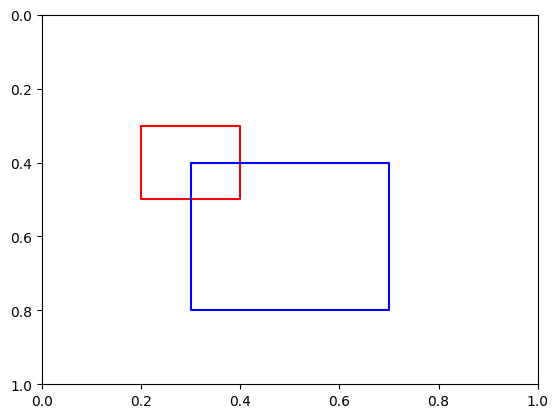

In [391]:
print(O(bb1,bb2))
plot_bounding_boxes( bb1, bb2 )

In [392]:
calculate_angle(bb1, bb2)

45.00000426886817

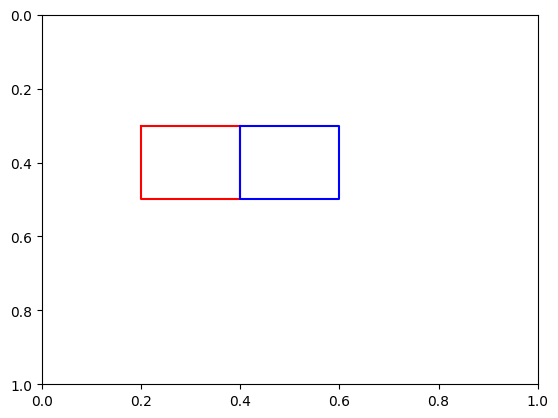

In [393]:
bb1 = torch.tensor([0.3, 0.4, 0.2, 0.2]) # vermelho
bb2 = torch.tensor([0.5, 0.4, 0.2, 0.2]) # azul
plot_bounding_boxes( bb1, bb2 )

# Funções do Odailson Modificadas por Nós

In [394]:
def get_coordinates( bb ):
    x0 = bb[ 0 ]
    y0 = bb[ 1 ]
    x1 = bb[ 0 ] + bb[ -2 ]
    y1 = bb[ 1 ] + bb[ -1 ]
    return [ x0, y0, x1, y1 ]

In [395]:
def calculate_angle( b1, b2 ):
    print(b1,b2)
    if(len(b1) > 1):
      try:
        aux1 = b1[0]
        aux2 = b2[0]
        c2 = np.array( (aux2[ 0 ], aux2[ 1 ]) )
        c1 = np.array( (aux1[ 0 ], aux1[ 1 ]) )
        x = c2 - c1

        return np.angle( x[ 0 ] + 1j * x[ 1 ], deg = True )
      except:
        bb1 = b1
        bb2 = b2
        c2 = np.array( (bb2[ 0 ], bb2[ 1 ]) )
        c1 = np.array( (bb1[ 0 ], bb1[ 1 ]) )
        x = c2 - c1

        return np.angle( x[ 0 ] + 1j * x[ 1 ], deg = True )
    else:
      return calculate_angle(b1[0],b2[0])


In [396]:
def plot_bounding_boxes( bb1: torch.Tensor, bb2: torch.Tensor, is_class_first = False,
                         is_yolo_format = False ):
    """
    Plot two bounding boxes on a 2D plane.

    Parameters:
        bb1 (tensor): The coordinates of the first bounding box.
        bb2 (tensor): The coordinates of the second bounding box.
        is_class_first (bool, optional): If True, assumes the class is the first element in each bounding box. Default is False.
        is_yolo_format (bool, optional): If True, assumes the bounding boxes are in YOLO format. Default is False.

    Example:
        bb1 = tf.constant([0.3, 0.3, 0.2, 0.2])
        bb2 = tf.constant([0.3, 0.3, 0.1, 0.1])
        plot_bounding_boxes(bb1, bb2, is_class_first=True, is_yolo_format=True)
    """
    (x1, y1, w1, h1), (x2, y2, w2, h2) = translate_bbs( bb1, bb2, is_class_first, is_yolo_format )

    plt.figure( )
    plt.plot( [ x1 - w1 / 2, x1 + w1 / 2, x1 + w1 / 2, x1 - w1 / 2, x1 - w1 / 2 ],
              [ y1 - h1 / 2, y1 - h1 / 2, y1 + h1 / 2, y1 + h1 / 2, y1 - h1 / 2 ],
              'r' )

    plt.plot( [ x2 - w2 / 2, x2 + w2 / 2, x2 + w2 / 2, x2 - w2 / 2, x2 - w2 / 2 ],
              [ y2 - h2 / 2, y2 - h2 / 2, y2 + h2 / 2, y2 + h2 / 2, y2 - h2 / 2 ],
              'b' )

    plt.xlim( 0, 1 )
    plt.ylim( 0, 1 )
    #plt.gca( ).invert_yaxis( )
    plt.show( )

# Nossa Implementação

função para retornar os pontos de um bounding box

In [397]:
def get_points(b1):
  try:
    bb1 = b1[0]
    w = bb1[2] # width
    h = bb1[3] # height
  except:
    bb1 = b1
    w = bb1[2]
    h = bb1[3]

  # ----- calcular os pontos -----
  x0 = bb1[0] - w/2
  y0 = bb1[1] - h/2

  x2 = bb1[0] + w/2
  y2 = bb1[1] - h/2

  x1 = bb1[0] + w/2
  y1 = bb1[1] + h/2

  x3 = bb1[0] - w/2
  y3 = bb1[1] + h/2

  return [(x0,y0), (x2,y2), (x1,y1),(x3,y3)]

função que verifica quais pontos de um bonding box estao dentro de outro bounding box

In [398]:
def isPointInside(p1, bb: torch.Tensor):
  bb_points = get_points(bb) # pega os pontos do bounding box

  # ---- extrai os valores de minimo e maximo do x e y -----
  xmin = bb_points[0][0]
  xmax = bb_points[1][0]
  ymin = bb_points[0][1]
  ymax = bb_points[2][1]
  #print(f'xmin: {xmin}, xmax: {xmax}, ymin: {ymin}, ymax: {ymax}')

  # ---- verifica se o ponto esta dentro dos limites do bounding box -----
  if(p1[0] >= xmin and p1[0] <= xmax and p1[1] >= ymin and p1[1] <= ymax):
    return True
  else:
    return False


função que retorna quais pontos de bb1 estao dentro de bb2

In [399]:
def getPointsInside(bb1 : torch.Tensor, bb2 : torch.Tensor):
  print(bb1, bb2)
  points_bb1 = get_points(bb1) # pega os pontos do bounding box
  points_inside = []

  # ----- verificar quais pontos estao dentro do bounding box -----
  for p1 in points_bb1:
    if(isPointInside(p1, bb2)):
      points_inside.append(p1)

  return points_inside

funções para verificar máximo e mínimo das coordenadas

In [400]:
def get_min_x(bb1):
  points = get_points(bb1) # pega os pontos do bounding box

  # --- verificar qual x é o menor ---
  min_x = points[0][0]
  for point in points[1:]:
    if(point[0] < min_x):
      min_x = point[0]
  #print("min x:", min_x)
  return min_x


def get_max_x(bb1):
  points = get_points(bb1) # pega os pontos do bounding box

  # ----- verificar qual x é o maior -----
  max_x = points[0][0]
  for point in points[1:]:
    if(point[0] > max_x):
      max_x = point[0]
  #print("max x:", max_x)
  return max_x


def get_min_y(bb1):
  points = get_points(bb1) # pega os pontos do bounding box

  # ----- verificar qual y é o menor -----
  min_y = points[0][1]
  for point in points[1:]:
    if(point[1] < min_y):
      min_y = point[1]
  #print("min y:", min_y)
  return min_y


def get_max_y(bb1):
  points = get_points(bb1) # pega os pontos do bounding box

  # ----- verificar qual y é o maior -----
  max_y = points[0][1]
  for point in points[1:]:
    if(point[1] > max_y):
      max_y = point[1]
  #print("max y:", max_y)
  return max_y

função para calcular área bounding box

In [401]:
def get_bb_area(bb):
  # simplesmente pegar a largura (índice 2) e multiplicar pela altura (índice 3)
  try:
    aux = bb[0]
    return aux[2] * aux[3]
  except:
    return bb[2] * bb[3]

### Funções auxiliares para encontrar a intereseção entre BB's

caso para um ponto dentro

In [402]:
def intersect_with_1_points_inside(bb1, bb2):
  insides1 = getPointsInside(bb1,bb2) # pegar os pontos de bb1 que estao dentro de bb2
  insides2 = getPointsInside(bb2,bb1) # pegar os pontos de bb2 que estao dentro de bb1

  if(len(insides1) >= len(insides2)): # se bb1 tiver mais pontos dentro de bb2 que o inverso
    insides = insides1
    # ----- identificar qual as posicoes dos bounding boxes e retornar os pontos -----

    for ins in insides:
      print("ponto de dentro:", ins)
      x = ins[0]
      y = ins[1]
      xmin = get_min_x(bb1)
      xmax = get_max_x(bb1)
      ymin = get_min_y(bb1)
      ymax = get_max_y(bb1)
      print('xmin:', xmin, ';xmax:', xmax, ';ymin:', ymin, ';ymax:', ymax)

      if (x == xmin):
        if(y == ymin):
          print("inferior esquerdo")
          print(get_max_x(bb2), get_max_y(bb2))
          print(f'({get_max_x(bb2)},{y}) ; ({x},{get_max_y(bb2)})')
          insides.append((get_max_x(bb2),y))
          insides.append((x,get_max_y(bb2)))
        else:
          print("superior esquerdo")
          print(get_max_x(bb2), get_min_y(bb2))
          print(f'({get_max_x(bb2)},{y}) ; ({x},{get_min_y(bb2)})')
          insides.append((get_max_x(bb2),y))
          insides.append((x,get_min_y(bb2)))
      else:
        if(y == ymin):
          print("inferior direito")
          print(get_min_x(bb2), get_max_y(bb2))
          print(f'({get_min_x(bb2)},{y}) ; ({x},{get_max_y(bb2)})')
          insides.append((get_min_x(bb2),y))
          insides.append((x,get_max_y(bb2)))
        else:
          print("superior direito")
          print(get_min_x(bb2), get_min_y(bb2))
          print(f'({get_min_x(bb2)},{y}) ; ({x},{get_min_y(bb2)})')
          insides.append((get_min_x(bb2),y))
          insides.append((x,get_min_y(bb2)))

      insides.append(getPointsInside(bb2,bb1)[0])
      return insides
  else: # caso bb2 tiver mais pontos dentro de bb1 que o inverso
    return intersect_with_1_points_inside(bb2,bb1)


caso para dois pontos dentro

In [403]:
def intersect_with_2_points_inside(bb1, bb2):
  insides1 = getPointsInside(bb1,bb2) # pegar os pontos de bb1 que estao dentro de bb2
  insides2 = getPointsInside(bb2,bb1) # pegar os pontos de bb2 que estao dentro de bb1

  if(len(insides1) >= len(insides2)): # se bb1 tiver mais pontos dentro de bb2 que o inverso
    insides = insides1
    insidePointsSituations = []

    # ----- identificar qual as posicoes dos bounding boxes e retornar os pontos -----
    for ins in insides:
      print("ponto de dentro:", ins)
      x = ins[0]
      y = ins[1]
      xmin = get_min_x(bb1)
      xmax = get_max_x(bb1)
      ymin = get_min_y(bb1)
      ymax = get_max_y(bb1)
      #print('xmin:', xmin, ';xmax:', xmax, ';ymin:', ymin, ';ymax:', ymax)

      if (x == xmin):
        if(y == ymin):
          print("inferior esquerdo")
          insidePointsSituations.append('ie')
        else:
          print("superior esquerdo")
          insidePointsSituations.append('se')
      else:
        if(y == ymin):
          print("inferior direito")
          insidePointsSituations.append('id')
        else:
          print("superior direito")
          insidePointsSituations.append('sd')

    print(insidePointsSituations)
    if('ie' in insidePointsSituations and 'id' in insidePointsSituations):
      print("duas retas subindo")
      min_x = get_min_x(bb1)
      max_x = get_max_x(bb1)
      max_y = get_max_y(bb2)
      insides.append((min_x,max_y))
      insides.append((max_x, max_y))
      print(min_x, max_y)
      print(max_x, max_y)
    elif('ie' in insidePointsSituations and 'se' in insidePointsSituations):
      print("duas retas para a direita")
      max_x = get_max_x(bb2)
      max_y = get_max_y(bb1)
      min_y = get_min_y(bb1)
      insides.append((max_x, max_y))
      insides.append((max_x, min_y))
      print(max_x, max_y)
      print(max_x, min_y)
    elif('sd' in insidePointsSituations and 'se' in insidePointsSituations):
      print('duas retas descendo')
      min_x = get_min_x(bb1)
      max_x = get_max_x(bb1)
      min_y = get_min_y(bb2)
      insides.append((min_x, min_y))
      insides.append((max_x, min_y))
      print(min_x, min_y)
      print(max_x, min_y)
    else:
      print('duas retas para a esquerda')
      min_x = get_min_x(bb2)
      max_y = get_max_y(bb1)
      min_y = get_min_y(bb1)
      insides.append((min_x, max_y))
      insides.append((min_x, min_y))
      print(min_x, max_y)
      print(min_x, min_y)

    return [insides[2],insides[3],insides[1],insides[0]]
  else: # caso bb2 tiver mais pontos dentro de bb1 que o inverso
    return intersect_with_2_points_inside(bb2, bb1)

caso para nenhum ponto dentro

In [404]:
def intersect_with_0_points_inside(bb1, bb2):
  # ----- descobrir qual o bounding box com maiores maximos e minimos para x -----
  if(get_min_x(bb1) >= get_min_x(bb2) and get_max_x(bb1) <= get_max_x(bb2)):
    b1 = bb1
    b2 = bb2
  else:
    b1 = bb2
    b2 = bb1

  # ----- retornar os pontos -----
  p3 = (get_min_x(b1), get_max_y(b2))
  p4 = (get_max_x(b1), get_max_y(b2))
  p2 = (get_max_x(b1), get_min_y(b2))
  p1 = (get_min_x(b1), get_min_y(b2))
  return [p1,p2,p3,p4]

### O Convertido

In [405]:
def _O(bb1 : torch.Tensor, bb2 : torch.Tensor):
  # ---------- descobrir qual situacao os bb's estao ----------

  # verificar quais e quantos pontos estao dentro
  bb1_points_inside_bb2 = getPointsInside(bb1, bb2)
  bb2_points_inside_bb1 = getPointsInside(bb2, bb1)

  # corrigir bug
  if(bb2_points_inside_bb1 > bb1_points_inside_bb2):
    bb1_points_inside_bb2 = bb2_points_inside_bb1
    aux = bb1
    bb1 = bb2
    bb2 = aux

  quantity_inside_points = len(bb1_points_inside_bb2)

  # pegar medidas para verificar se estao totalmente sobrepostos ou nao
  min_x_bb1 = get_min_x(bb1)
  max_x_bb1 = get_max_x(bb1)
  min_x_bb2 = get_min_x(bb2)
  max_x_bb2 = get_max_x(bb2)
  min_y_bb1 = get_min_y(bb1)
  max_y_bb1 = get_max_y(bb1)
  min_y_bb2 = get_min_y(bb2)
  max_y_bb2 = get_max_y(bb2)

  # caso em que estao totalmente disjuntos
  if(min_x_bb2 >= max_x_bb1 or min_x_bb1 >= max_x_bb2 or min_y_bb2 >= max_y_bb1 or min_y_bb1 >= max_y_bb2):
    print("totalmente disjuntos")
    return torch.tensor(0.0)
  elif(quantity_inside_points == 0): # 0 pontos de nao disjuncao
    print("0 pontos de nao disjuncao")
    intersect_points = intersect_with_0_points_inside(bb1, bb2)
  elif(quantity_inside_points == 1): # 1 pontos de nao disjuncao
    print("1 pontos de nao disjuncao")
    intersect_points = intersect_with_1_points_inside(bb1, bb2)
  elif(quantity_inside_points == 2): # 2 pontos de nao disjuncao
    print("2 pontos de nao disjuncao")
    intersect_points = intersect_with_2_points_inside(bb1, bb2)
  else: # bb's se sobrepoem totalmente
    print("totalmente nao disjuntos")
    return torch.tensor(1.0)

  # ---------- calcular areas para descobrir o quao disjuntos os bb's estao ----------
  print(intersect_points)

  # area_z = area do bounding box de intersecao entre bb1 e bb2, area_x = area do bb1, area_y = area do bb2
  area_z = (intersect_points[1][0] - intersect_points[0][0]) * (intersect_points[2][1] - intersect_points[0][1])
  area_x = get_bb_area(bb1)
  area_y = get_bb_area(bb2)

  # porcentagem de intersecao calculada com a formula do MIRO
  percentage = area_z / (area_x + area_y - area_z)
  print(area_x, area_y, area_z, percentage)
  return percentage

### D Convertido

In [406]:
def _D(bb1 : torch.Tensor, bb2 : torch.Tensor):
  # ---------- descobrir qual situacao os bb's estao ----------

  # verificar quais e quantos pontos estao dentro
  bb1_points_inside_bb2 = getPointsInside(bb1, bb2)
  bb2_points_inside_bb1 = getPointsInside(bb2, bb1)

  # corrigir bug
  if(bb2_points_inside_bb1 > bb1_points_inside_bb2):
    bb1_points_inside_bb2 = bb2_points_inside_bb1
    aux = bb1
    bb1 = bb2
    bb2 = aux

  quantity_inside_points = len(bb1_points_inside_bb2)

  # pegar medidas para verificar se estao totalmente disjuntos ou nao
  min_x_bb1 = get_min_x(bb1)
  max_x_bb1 = get_max_x(bb1)
  min_x_bb2 = get_min_x(bb2)
  max_x_bb2 = get_max_x(bb2)
  min_y_bb1 = get_min_y(bb1)
  max_y_bb1 = get_max_y(bb1)
  min_y_bb2 = get_min_y(bb2)
  max_y_bb2 = get_max_y(bb2)

  # caso em que estao totalmente disjuntos
  if(min_x_bb2 >= max_x_bb1 or min_x_bb1 >= max_x_bb2 or min_y_bb2 >= max_y_bb1 or min_y_bb1 >= max_y_bb2):
    print("totalmente disjuntos")
    return torch.tensor(1.0)
  elif(quantity_inside_points == 0): # 0 pontos de nao disjuncao
    print("0 pontos de nao disjuncao")
    intersect_points = intersect_with_0_points_inside(bb1, bb2)
  elif(quantity_inside_points == 1): # 1 pontos de nao disjuncao
    print("1 pontos de nao disjuncao")
    intersect_points = intersect_with_1_points_inside(bb1, bb2)
  elif(quantity_inside_points == 2): # 2 pontos de nao disjuncao
    print("2 pontos de nao disjuncao")
    intersect_points = intersect_with_2_points_inside(bb1, bb2)
  else: # bb's se sobrepoem totalmente
    print("totalmente nao disjuntos")
    return torch.tensor(0.0)

  # ---------- calcular areas para descobrir o quao disjuntos os bb's estao ----------
  print(intersect_points)

  # area_z = area do bounding box de intersecao entre bb1 e bb2, area_x = area do bb1, area_y = area do bb2
  area_z = (intersect_points[1][0] - intersect_points[0][0]) * (intersect_points[2][1] - intersect_points[0][1])
  area_x = get_bb_area(bb1)
  area_y = get_bb_area(bb2)

  # porcentagem de intersecao calculada com a formula do MIRO
  percentage = (area_x + area_y - 2 * area_z)/(area_x + area_y - area_z)
  return percentage

### PO Convertido

In [407]:
def _PO(bb1 : torch.Tensor, bb2 : torch.Tensor):
  # ---------- descobrir qual situacao os bb's estao ----------

  # verificar quais e quantos pontos estao dentro
  bb1_points_inside_bb2 = getPointsInside(bb1, bb2)
  bb2_points_inside_bb1 = getPointsInside(bb2, bb1)

  # corrigir bug
  if(bb2_points_inside_bb1 > bb1_points_inside_bb2):
    bb1_points_inside_bb2 = bb2_points_inside_bb1
    aux = bb1
    bb1 = bb2
    bb2 = aux

  quantity_inside_points = len(bb1_points_inside_bb2)

  # pegar medidas para verificar se estao totalmente sobrepostos ou nao
  min_x_bb1 = get_min_x(bb1)
  max_x_bb1 = get_max_x(bb1)
  min_x_bb2 = get_min_x(bb2)
  max_x_bb2 = get_max_x(bb2)
  min_y_bb1 = get_min_y(bb1)
  max_y_bb1 = get_max_y(bb1)
  min_y_bb2 = get_min_y(bb2)
  max_y_bb2 = get_max_y(bb2)

  # caso em que estao totalmente disjuntos
  if(min_x_bb2 >= max_x_bb1 or min_x_bb1 >= max_x_bb2 or min_y_bb2 >= max_y_bb1 or min_y_bb1 >= max_y_bb2):
    print("totalmente disjuntos")
    return torch.tensor(0)
  elif(quantity_inside_points == 0): # 0 pontos de nao disjuncao
    print("0 pontos de nao disjuncao")
    intersect_points = intersect_with_0_points_inside(bb1, bb2)
  elif(quantity_inside_points == 1): # 1 pontos de nao disjuncao
    print("1 pontos de nao disjuncao")
    intersect_points = intersect_with_1_points_inside(bb1, bb2)
  elif(quantity_inside_points == 2): # 2 pontos de nao disjuncao
    print("2 pontos de nao disjuncao")
    intersect_points = intersect_with_2_points_inside(bb1, bb2)
  else: # bb's se sobrepoem totalmente
    print("totalmente nao disjuntos")
    return torch.tensor(0)

  # ---------- calcular areas para descobrir o quao disjuntos os bb's estao ----------
  print(intersect_points)

  # area_z = area do bounding box de intersecao entre bb1 e bb2, area_x = area do bb1, area_y = area do bb2
  area_z = (intersect_points[1][0] - intersect_points[0][0]) * (intersect_points[2][1] - intersect_points[0][1])
  area_x = get_bb_area(bb1)
  area_y = get_bb_area(bb2)

  # porcentagem de intersecao calculada com a formula do MIRO
  O = area_z / ((area_x + area_y) - area_z)
  D = ((area_x + area_y) - 2* area_z)/(area_x + area_y - area_z)
  I1 = O - torch.tensor(0.5)
  I2 = D - torch.tensor(0.5)
  print(I1,I2)
  percentage = torch.tensor(1) - (I1 + I2)

  return percentage

### Predicados de posição

In [408]:
def right_of(bb1, bb2):
  angle = calculate_angle(bb1, bb2) # calcular o angulo entre os centros dos bounding boxes
  if(angle >= -90 and angle <= 90):
    return torch.tensor(math.cos(angle)**2) # cosseno do angulo ao quadrado
  return torch.tensor(0)

def below(bb1, bb2):
  angle = calculate_angle(bb1, bb2) # calcular o angulo entre os centros dos bounding boxes
  if(angle >= 0 and angle <= 180):
    return torch.tensor(math.sin(angle)**2) # seno do angulo ao quadrado
  return torch.tensor(0)

def above(bb1, bb2):
  angle = calculate_angle(bb1, bb2) # calcular o angulo entre os centros dos bounding boxes
  if(angle >= -180 and angle <= 0):
    return torch.tensor(math.sin(angle)**2) # seno do angulo ao quadrado
  return torch.tensor(0)

def left_of(bb1, bb2):
  angle = calculate_angle(bb1, bb2) # calcular o angulo entre os centros dos bounding boxes
  if((angle >= -180 and angle <= -90) or (angle >= 90 and angle <= 180)):
    return torch.tensor(math.cos(angle)**2) # cosseno do angulo ao quadrado
  return torch.tensor(0)

# Transformando em Predicados em LTN

gerar um predicado em LTN para cada predicado no formato de função

In [ ]:
abovePredicate = ltn.Predicate(func=above)
belowPredicate = ltn.Predicate(func=below)
rightPredicate = ltn.Predicate(func=right_of)
leftPredicate = ltn.Predicate(func=left_of)
OPredicate = ltn.Predicate(func = _O)
POPredicate = ltn.Predicate(func = _PO)
DPredicate = ltn.Predicate(func = _D)

definindo seus bounding boxes

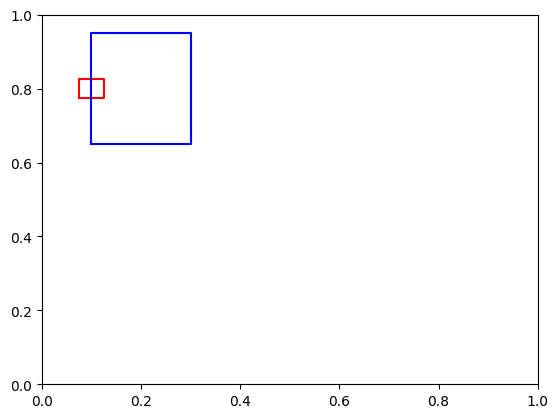

In [ ]:
bb1 = torch.tensor([0.1, 0.8, 0.05, 0.05])  # QUADRADO VERMELHO
bb2 = torch.tensor([0.2, 0.8, 0.2, 0.3])  # QYUADRADO AZUL
plot_bounding_boxes(bb1, bb2)

## juntando predicados

In [ ]:
And = ltn.Connective(ltn.fuzzy_ops.AndProd()) # conectivo AND do LTN Torch

### Predicados LTN - Posições Relativas (Right, Left, Below, Above)

In [ ]:
def ltnAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return abovePredicate(bb1_ltn, bb2_ltn)

ltnAbove(bb2, bb1)

tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])


LTNObject(value=tensor(0.7992), free_vars=[])

In [ ]:
def ltnRight(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return rightPredicate(bb1_ltn, bb2_ltn)

ltnRight(bb1, bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])


LTNObject(value=tensor(0.2008), free_vars=[])

In [ ]:
def ltnLeft(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return leftPredicate(bb1_ltn, bb2_ltn)

ltnLeft(bb2, bb1)

tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])


LTNObject(value=tensor(0.2008), free_vars=[])

In [ ]:
def ltnBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return belowPredicate(bb1_ltn, bb2_ltn)

ltnBelow(bb1, bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])


LTNObject(value=tensor(0.7992), free_vars=[])

### Predicados LTN - In

In [ ]:
def ltnInSideLeftAbove(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(And(abovePredicate(bb1_ltn, bb2_ltn), leftPredicate(bb1_ltn, bb2_ltn) ), OPredicate(bb1_ltn, bb2_ltn))

ltnInSideLeftAbove(bb2,bb1)

tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1500, 0.9000, 0.0500, 0.0500]])
tensor([0.2000, 0.8000, 0.2000, 0.3000]) tensor([0.1500, 0.9000, 0.0500, 0.0500])
tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1500, 0.9000, 0.0500, 0.0500]])
tensor([0.2000, 0.8000, 0.2000, 0.3000]) tensor([0.1500, 0.9000, 0.0500, 0.0500])
tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1500, 0.9000, 0.0500, 0.0500]])
tensor([[0.1500, 0.9000, 0.0500, 0.0500]]) tensor([[0.2000, 0.8000, 0.2000, 0.3000]])
totalmente nao disjuntos


LTNObject(value=tensor(0.0002), free_vars=[])

In [ ]:
def ltnInAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(abovePredicate(bb1_ltn, bb2_ltn), OPredicate(bb1_ltn, bb2_ltn))

ltnInAbove(bb2, bb1)

tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(7.9925e-05), free_vars=[])

In [ ]:
def ltnInSideRightAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(abovePredicate(bb1_ltn, bb2_ltn), rightPredicate(bb1_ltn, bb2_ltn) ), OPredicate(bb1_ltn, bb2_ltn))

ltnInSideRightAbove(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.2008e-08), free_vars=[])

In [ ]:
def ltnInSideRight(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(rightPredicate(bb1_ltn, bb2_ltn), OPredicate(bb1_ltn, bb2_ltn))

ltnInSideRight(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(2.0085e-05), free_vars=[])

In [ ]:
def ltnInSideRightBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(belowPredicate(bb1_ltn, bb2_ltn), rightPredicate(bb1_ltn, bb2_ltn) ), OPredicate(bb1_ltn, bb2_ltn))

ltnInSideRightBelow(bb2,bb1)

tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.2008e-08), free_vars=[])

In [ ]:
def ltnInBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(belowPredicate(bb1_ltn, bb2_ltn), OPredicate(bb1_ltn, bb2_ltn))

ltnInBelow(bb2, bb1)

tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.0000e-08), free_vars=[])

In [ ]:
def ltnInSideLeftBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(belowPredicate(bb1_ltn, bb2_ltn), leftPredicate(bb1_ltn, bb2_ltn)), OPredicate(bb1_ltn, bb2_ltn))

ltnInSideLeftBelow(bb2,bb1)

tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([0.4000, 0.8000, 0.2000, 0.3000]) tensor([0.4000, 0.3000, 0.2000, 0.3000])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.2008e-08), free_vars=[])

In [ ]:
def ltnInSideLeft(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(leftPredicate(bb1_ltn, bb2_ltn), OPredicate(bb1_ltn, bb2_ltn))

ltnInSideLeft(bb2,bb1)

tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1500, 0.8000, 0.0500, 0.0500]])
tensor([0.2000, 0.8000, 0.2000, 0.3000]) tensor([0.1500, 0.8000, 0.0500, 0.0500])
tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1500, 0.8000, 0.0500, 0.0500]])
tensor([[0.1500, 0.8000, 0.0500, 0.0500]]) tensor([[0.2000, 0.8000, 0.2000, 0.3000]])
totalmente nao disjuntos


LTNObject(value=tensor(0.3582), free_vars=[])

### Predicados LTN - Edge

In [ ]:
def ltnEdgeSideLeftAbove(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(And(abovePredicate(bb1_ltn, bb2_ltn), leftPredicate(bb1_ltn, bb2_ltn) ), POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeSideLeftAbove(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.2008e-08), free_vars=[])

In [ ]:
def ltnEdgeAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(abovePredicate(bb1_ltn, bb2_ltn), POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeAbove(bb1, bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.0000e-08), free_vars=[])

In [ ]:
def ltnEdgeSideRightAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(abovePredicate(bb1_ltn, bb2_ltn), rightPredicate(bb1_ltn, bb2_ltn) ), POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeSideRightAbove(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.2008e-08), free_vars=[])

In [ ]:
def ltnEdgeSideRight(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(rightPredicate(bb1_ltn, bb2_ltn) , POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeSideRight(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(2.0085e-05), free_vars=[])

In [ ]:
def ltnEdgeSideRightBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(belowPredicate(bb1_ltn, bb2_ltn), rightPredicate(bb1_ltn, bb2_ltn)), POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeSideRightBelow(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.6061e-05), free_vars=[])

In [ ]:
def ltnEdgeBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(belowPredicate(bb1_ltn, bb2_ltn), POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeBelow(bb1, bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(7.9925e-05), free_vars=[])

In [ ]:
def ltnEdgeSideLeftBelow(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(And(belowPredicate(bb1_ltn, bb2_ltn), leftPredicate(bb1_ltn, bb2_ltn) ), POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeSideLeftBelow(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.6061e-05), free_vars=[])

In [ ]:
def ltnEdgeSideLeft(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(leftPredicate(bb1_ltn, bb2_ltn) , POPredicate(bb1_ltn, bb2_ltn))

ltnEdgeSideLeft(bb2,bb1)

tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1000, 0.8000, 0.0500, 0.0500]])
tensor([0.2000, 0.8000, 0.2000, 0.3000]) tensor([0.1000, 0.8000, 0.0500, 0.0500])
tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1000, 0.8000, 0.0500, 0.0500]])
tensor([[0.1000, 0.8000, 0.0500, 0.0500]]) tensor([[0.2000, 0.8000, 0.2000, 0.3000]])
2 pontos de nao disjuncao
tensor([[0.1000, 0.8000, 0.0500, 0.0500]]) tensor([[0.2000, 0.8000, 0.2000, 0.3000]])
tensor([[0.2000, 0.8000, 0.2000, 0.3000]]) tensor([[0.1000, 0.8000, 0.0500, 0.0500]])
ponto de dentro: (tensor(0.1250), tensor(0.7750))
inferior direito
ponto de dentro: (tensor(0.1250), tensor(0.8250))
superior direito
['id', 'sd']
duas retas para a esquerda
tensor(0.1000) tensor(0.8250)
tensor(0.1000) tensor(0.7750)
[(tensor(0.1000), tensor(0.8250)), (tensor(0.1000), tensor(0.7750)), (tensor(0.1250), tensor(0.8250)), (tensor(0.1250), tensor(0.7750))]
tensor(-0.5000) tensor(0.5000)


LTNObject(value=tensor(0.3582), free_vars=[])

### Predicados LTN - Out

In [ ]:
def ltnOutSideLeftAbove(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(And(abovePredicate(bb1_ltn, bb2_ltn), leftPredicate(bb1_ltn, bb2_ltn) ), DPredicate(bb1_ltn, bb2_ltn))

ltnOutSideLeftAbove(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.0001), free_vars=[])

In [ ]:
def ltnOutAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(abovePredicate(bb1_ltn, bb2_ltn), DPredicate(bb1_ltn, bb2_ltn))

ltnOutAbove(bb1, bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(1.0000e-04), free_vars=[])

In [ ]:
def ltnOutSideRightAbove(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(abovePredicate(bb1_ltn, bb2_ltn), rightPredicate(bb1_ltn, bb2_ltn) ), DPredicate(bb1_ltn, bb2_ltn))

ltnOutSideRightAbove(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.0001), free_vars=[])

In [ ]:
def ltnOutSideRight(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(rightPredicate(bb1_ltn, bb2_ltn) , DPredicate(bb1_ltn, bb2_ltn))

ltnOutSideRight(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.2008), free_vars=[])

In [ ]:
def ltnOutSideRightBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(And(belowPredicate(bb1_ltn, bb2_ltn), rightPredicate(bb1_ltn, bb2_ltn)), DPredicate(bb1_ltn, bb2_ltn))

ltnOutSideRightBelow(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.1606), free_vars=[])

In [ ]:
def ltnOutBelow(bb1 : torch.tensor, bb2 : torch.tensor):
  bb1_ltn = ltn.Constant(bb1)
  bb2_ltn = ltn.Constant(bb2)
  return And(belowPredicate(bb1_ltn, bb2_ltn), DPredicate(bb1_ltn, bb2_ltn))

ltnOutBelow(bb1, bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.7993), free_vars=[])

In [ ]:
def ltnOutSideLeftBelow(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(And(belowPredicate(bb1_ltn, bb2_ltn), leftPredicate(bb1_ltn, bb2_ltn) ), DPredicate(bb1_ltn, bb2_ltn))

ltnOutSideLeftBelow(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.1606), free_vars=[])

In [ ]:
def ltnOutSideLeft(bb1 : torch.tensor, bb2 : torch.tensor):
   bb1_ltn = ltn.Constant(bb1)
   bb2_ltn = ltn.Constant(bb2)
   return And(leftPredicate(bb1_ltn, bb2_ltn) , DPredicate(bb1_ltn, bb2_ltn))

ltnOutSideLeft(bb1,bb2)

tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([0.4000, 0.3000, 0.2000, 0.3000]) tensor([0.4000, 0.8000, 0.2000, 0.3000])
tensor([[0.4000, 0.3000, 0.2000, 0.3000]]) tensor([[0.4000, 0.8000, 0.2000, 0.3000]])
tensor([[0.4000, 0.8000, 0.2000, 0.3000]]) tensor([[0.4000, 0.3000, 0.2000, 0.3000]])
totalmente disjuntos


LTNObject(value=tensor(0.2008), free_vars=[])

# Training with Equally Spaced (Não conseguimos finalizar)

Gerando os bounding boxes com a função do Odailson (na seção codes originais)

In [ ]:
bb1 = [0.5, 0.5, 0.4, 0.8]  # Bounding box central usado como base para gerar a imagem
boxes = generate_eq_spaced_bbs_in_(bb1)
print('boxes : ', boxes)
plot_all_bb_with_names(bb1, boxes)

In [ ]:
boxes

In [ ]:
bboxes = []
for elem in boxes:
    bboxes.append((boxes[elem]))

In [ ]:
bboxes

In [ ]:
class ModelC(torch.nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dense1 = torch.nn.Linear(2, 5)
        self.dense2 = torch.nn.Linear(5, 5)
        self.dense3 = torch.nn.Linear(5, 2)

    def forward(self, x, l):
        x = self.elu(self.dense1(x))
        x = self.elu(self.dense2(x))
        prob = self.softmax(self.dense3(x))
        return torch.sum(prob * l, dim=1)

C = ltn.Predicate(ModelC())


In [ ]:
#declarando predicados
ltnAbovePredicate = ltn.Predicate(func=ltnAbove)
ltnRightPredicate = ltn.Predicate(func=ltnRight)
ltnLeftPredicate = ltn.Predicate(func=ltnLeft)
ltnBelowPredicate = ltn.Predicate(func=ltnBelow)
ltnInSideLeftAbovePredicate = ltn.Predicate(func=ltnInSideLeftAbove)
ltnInAbovePredicate = ltn.Predicate(func=ltnInAbove)
ltnInSideRightAbovePredicate = ltn.Predicate(func=ltnInSideRightAbove)
ltnInSideRightPredicate = ltn.Predicate(func=ltnInSideRight)
ltnInSideRightBelowPredicate = ltn.Predicate(func=ltnInSideRightBelow)
ltnInBelowPredicate = ltn.Predicate(func=ltnInBelow)
ltnInSideLeftBelowPredicate = ltn.Predicate(func=ltnInSideLeftBelow)
ltnInSideLeftPredicate = ltn.Predicate(func=ltnInSideLeft)
ltnEdgeSideLeftAbovePredicate = ltn.Predicate(func=ltnEdgeSideLeftAbove)
ltnEdgeAbovePredicate = ltn.Predicate(func=ltnEdgeAbove)
ltnEdgeSideRightAbovePredicate = ltn.Predicate(func=ltnEdgeSideRightAbove)
ltnEdgeSideRightPredicate = ltn.Predicate(func=ltnEdgeSideRight)
ltnEdgeSideRightBelowPredicate = ltn.Predicate(func=ltnEdgeSideRightBelow)
ltnEdgeBelowPredicate = ltn.Predicate(func=ltnEdgeBelow)
ltnEdgeSideLeftBelowPredicate = ltn.Predicate(func=ltnEdgeSideLeftBelow)
ltnEdgeSideLeftPredicate = ltn.Predicate(func=ltnEdgeSideLeft)
ltnOutSideLeftAbovePredicate = ltn.Predicate(func=ltnOutSideLeftAbove)
ltnOutAbovePredicate = ltn.Predicate(func=ltnOutAbove)
ltnOutSideRightAbovePredicate = ltn.Predicate(func=ltnOutSideRightAbove)
ltnOutSideRightPredicate = ltn.Predicate(func=ltnOutSideRight)
ltnOutSideRightBelowPredicate = ltn.Predicate(func=ltnOutSideRightBelow)
ltnOutBelowPredicate = ltn.Predicate(func=ltnOutBelow)
ltnOutSideLeftBelowPredicate = ltn.Predicate(func=ltnOutSideLeftBelow)
ltnOutSideLeftPredicate = ltn.Predicate(func=ltnOutSideLeft)


In [ ]:
#variables and constants
x1 = ltn.Variable("x1", torch.tensor(bboxes))
x2 = ltn.Variable("x2", torch.tensor(bboxes))
#labels
#in - edge - out - right - left - above - bellow
l_ltnAbove = ltn.Constant(torch.Tensor([0,0,0,0,0,1,0]))
l_ltnRight = ltn.Constant(torch.Tensor([0,0,0,1,0,0,0]))
l_ltnLeft = ltn.Constant(torch.Tensor([0,0,0,0,1,0,0]))
l_ltnBelow = ltn.Constant(torch.Tensor([0,0,0,0,0,0,1]))
l_ltnInSideLeftAbove = ltn.Constant(torch.Tensor([1,0,0,0,1,0,0]))
l_ltnInAbove = ltn.Constant(torch.Tensor([1,0,0,0,0,1,0]))
l_ltnInSideRightAbove = ltn.Constant(torch.Tensor([1,0,0,1,0,1,0]))
l_ltnInSideRight = ltn.Constant(torch.Tensor([1,0,0,1,0,0,0]))
l_ltnInSideRightBelow = ltn.Constant(torch.Tensor([1,0,0,1,0,0,1]))
l_ltnInBelow = ltn.Constant(torch.Tensor([1,0,0,0,0,0,1]))
l_ltnInSideLeftBelow = ltn.Constant(torch.Tensor([1,0,0,0,1,0,1]))
l_ltnInSideLeft = ltn.Constant(torch.Tensor([1,0,0,0,1,0,0]))
l_ltnEdgeSideLeftAbove = ltn.Constant(torch.Tensor([0,1,0,0,1,0,0]))
l_ltnEdgeAbove = ltn.Constant(torch.Tensor([0,1,0,0,0,1,0]))
l_ltnEdgeSideRightAbove = ltn.Constant(torch.Tensor([0,1,0,1,0,1,0]))
l_ltnEdgeSideRight = ltn.Constant(torch.Tensor([0,1,0,1,0,0,0]))
l_ltnEdgeSideRightBelow = ltn.Constant(torch.Tensor([0,1,0,1,0,0,1]))
l_ltnEdgeBelow = ltn.Constant(torch.Tensor([0,1,0,0,0,0,1]))
l_ltnEdgeSideLeftBelow = ltn.Constant(torch.Tensor([0,1,0,0,1,0,1]))
l_ltnEdgeSideLeft = ltn.Constant(torch.Tensor([0,1,0,0,1,0,0]))
l_ltnOutSideLeftAbove = ltn.Constant(torch.Tensor([0,0,1,0,1,1,0]))
l_ltnOutAbove = ltn.Constant(torch.Tensor([0,0,1,0,0,1,0]))
l_ltnOutSideRightAbove = ltn.Constant(torch.Tensor([0,0,1,1,0,1,0]))
l_ltnOutSideRight = ltn.Constant(torch.Tensor([0,0,1,1,0,0,0]))
l_ltnOutSideRightBelow = ltn.Constant(torch.Tensor([0,0,1,1,0,0,1]))
l_ltnOutBelow = ltn.Constant(torch.Tensor([0,0,1,0,0,0,1]))
l_ltnOutSideLeftBelow = ltn.Constant(torch.Tensor([0,0,1,0,1,0,1]))
l_ltnOutSideLeft = ltn.Constant(torch.Tensor([0,0,1,0,1,0,0]))
labels = [[0,0,0,0,0,1,0],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1],[0,0,0,0,0,0,1],
 [1,0,0,0,1,0,0],[1,0,0,0,0,1,0],[1,0,0,1,0,1,0],[1,0,0,1,0,0,0],[1,0,0,1,0,0,1],
 [1,0,0,0,0,0,1],[1,0,0,0,1,0,1],[1,0,0,0,1,0,0],[0,1,0,0,1,0,0],[0,1,0,0,0,1,0],
 [0,1,0,1,0,1,0],[0,1,0,1,0,0,0],[0,1,0,1,0,0,1],[0,1,0,0,0,0,1],[0,1,0,0,1,0,1],
 [0,1,0,0,1,0,0],[0,0,1,0,1,1,0],[0,0,1,0,0,1,0],[0,0,1,1,0,1,0],[0,0,1,1,0,0,0],
 [0,0,1,1,0,0,1],[0,0,1,0,0,0,1],[0,0,1,0,1,0,1],[0,0,1,0,1,0,0]]
l = ltn.Variable("l", torch.tensor(labels))

In [ ]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

# Testes

In [ ]:
# by default, SatAgg uses the pMeanError
sat_agg = ltn.fuzzy_ops.SatAgg()

# we need to learn the parameters of the predicate C
optimizer = torch.optim.Adam(C.parameters(), lr=0.001)

for epoch in range(2000):
    optimizer.zero_grad()
    loss = 1. - sat_agg(
        Forall([x1, x2, l], Implies(ltnAbovePredicate(x1, x2), C(x1,x2,l_ltnAbove))),
    )
    loss.backward()
    optimizer.step()
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f "%(epoch, 1 - loss.item()))
print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss.item()))